In [459]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import random
import OpenEXR
import Imath

In [460]:
# Custom transformations
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        if random.random() < self.p:
            sample = torch.flip(sample, dims=[2])
        return sample

class RandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        if random.random() < self.p:
            sample = torch.flip(sample, dims=[1])
        return sample

class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees
    
    def __call__(self, sample):
        angle = random.uniform(-self.degrees, self.degrees)
        sample = TF.functional.rotate(sample, angle)
        return sample

class Normalize:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def __call__(self, sample):
        return (sample - self.mean) / self.std


Train size: 600 | Train shape: torch.Size([2, 256, 256])
Validation size: 200 | Validation shape: torch.Size([2, 256, 256])
Test size: 200 | Test shape: torch.Size([2, 256, 256])


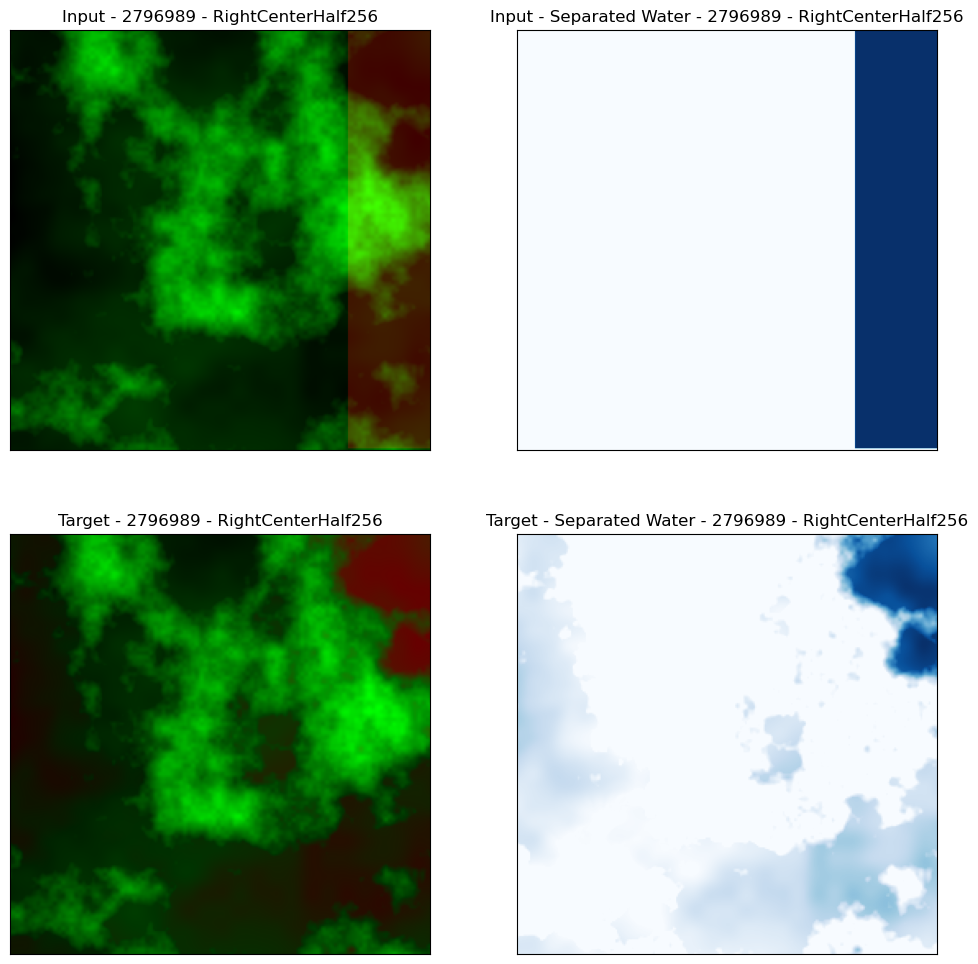

In [ ]:
class EXRDataset(Dataset):
    def __init__(self, directories, epsilon=0.01, transform=None):
        self.directories = directories
        self.transform = transform
        self.samples = []
        for directory in self.directories:
            files = sorted([f for f in os.listdir(directory) if f.endswith('.exr')])
            for f in files:
                seed, wave, height = parse_filename(f)
                self.samples.append((directory, f, seed, wave, height))
        if transform is not None:
            print(f'Initializing EXRDataset with transforms')
        
    

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = os.path.join(self.samples[idx][0], self.samples[idx][1])
        # print(f'ID: {idx} - FILE PATH: {file_path}')
        # Load EXR image
        exr_file = OpenEXR.InputFile(file_path)
        dw = exr_file.header()['dataWindow']
        width = dw.max.x - dw.min.x + 1
        height = dw.max.y - dw.min.y + 1
        assert(width == 256 and height == 256)
        
        # Extract channels
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        input_channels = [np.frombuffer(exr_file.channel(c, pt), dtype=np.float32).reshape(height, width) for c in ['R', 'G']]
        target_channels = [np.frombuffer(exr_file.channel(c, pt), dtype=np.float32).reshape(height, width) for c in ['B', 'A']]
        
        # Stack channels
        input = np.stack(input_channels, axis=0)  # Shape: (2, H, W)
        target = np.stack(target_channels, axis=0)  # Shape: (2, H, W)

        # Convert to tensors
        input = torch.tensor(input, dtype=torch.float32) # Shape: (2, H, W)
        target = torch.tensor(target, dtype=torch.float32)  # Shape: (2, H, W)

        # Subtract epsilon from first target channel to account for simulation's floating point error
        target[0] = target[0] - 0.01

        # Ensure that first channel of target is always 0 or greater
        target[0] = torch.max(target[0], torch.tensor(0.0))

        
        if self.transform:
            
            combined = torch.cat((input, target), dim=0)  # Shape: (4, H, W)
            combined = self.transform(combined)
            input = combined[:2, :, :]
            target = combined[2:, :, :]
    
        return input, target, idx


# Filenames should all be in the format S_#####_W_wavename_H_averageheight.exr
def parse_filename(filename):
    # print(filename)
    filename = os.path.basename(filename)
    filename = filename[0:-4]
    parts = filename.split('_')
    seed = parts[1]
    wave = parts[3]
    height = 0
    try:
        height = float(parts[5])
    except:
        print(f'Filename weirdness...: {filename}')
    return seed, wave, height


def load_dataset(batch_size, transform=None):
    #  get local path
    local_path = os.getcwd()

    directoryA = local_path + "/data_noise_a/"
    directoryB = local_path + "/data_noise_b/"
    directories = [directoryA, directoryB]
    dataset = EXRDataset(directories, transform=transform)


    # Split dataset into train and validation
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    # If there is time, work on stratification
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Print dataset sizes
    print(f"Train size: {len(train_dataset)} | Train shape: {train_dataset[0][0].shape}")
    print(f"Validation size: {len(val_dataset)} | Validation shape: {val_dataset[0][0].shape}")
    print(f"Test size: {len(test_dataset)} | Test shape: {test_dataset[0][0].shape}")
    
    return train_loader, val_loader, test_loader

#  input tensor shape: (2, H, W)
def convert_to_rgb(input):
    # print(input.shape)
    tmp = input.squeeze(0)  # Shape: (2, H, W)
    # print(tmp.shape)
    H,W = tmp.shape[1], tmp.shape[2]
    rgb_input = torch.zeros((H,W,3))
    rgb_input[:,:,0] = tmp[0]
    rgb_input[:,:,1] = tmp[1]

    return rgb_input


def verify_dataset():
    batch_size = 256
    tr_loader, va_loader, te_loader = load_dataset(batch_size)
    tr_inputs, tr_targets, idxs = next(iter(tr_loader))

    # Get the first image in the batch
    input = tr_inputs[0].squeeze(0).numpy()  # Shape: (2, H, W)
    target = tr_targets[0].squeeze(0).numpy()  # Shape: (2, H, W)
    
    dataset = tr_loader.dataset.dataset

    directory, file, seed, wave, height = dataset.samples[idxs[0]]
    
    input = convert_to_rgb(tr_inputs[0].squeeze(0))
    target = convert_to_rgb(tr_targets[0].squeeze(0))

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0,0].imshow(input, cmap='Blues')
    axs[0,0].set_title(f'Input - {seed} - {wave}')
    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])

    axs[0,1].imshow(tr_inputs[0][0], cmap='Blues')
    axs[0,1].set_title(f'Input - Separated Water - {seed} - {wave}')
    axs[0,1].set_xticks([])
    axs[0,1].set_yticks([])

    axs[1,0].imshow(target, cmap='gray')
    axs[1,0].set_title(f'Target - {seed} - {wave}')
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])

    axs[1,1].imshow(tr_targets[0][0], cmap='Blues')
    axs[1,1].set_title(f'Target - Separated Water - {seed} - {wave}')
    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([])
    plt.show()
    


verify_dataset()

In [462]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder: Downsampling Path
        self.enc1 = self.conv_block(2, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder: Upsampling Path
        self.up4 = self.upconv_block(256, 128)
        self.dec4 = self.conv_block(256, 128)

        self.up3 = self.upconv_block(128, 64)
        self.dec3 = self.conv_block(128, 64)

        self.up2 = self.upconv_block(64, 32)
        self.dec2 = self.conv_block(64, 32)

        self.up1 = self.upconv_block(32, 16)
        self.dec1 = self.conv_block(32, 16)

        # Final Output Layer
        self.final = nn.Conv2d(16, 2, kernel_size=1)

    def conv_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels, kernel_size=2, stride=2):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                                    # Output: (batch_size, 16, 256, 256)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))                # Output: (batch_size, 32, 128, 128)
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))                # Output: (batch_size, 64, 64, 64)
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))                # Output: (batch_size, 128, 32, 32)

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))    # Output: (batch_size, 256, 16, 16)

        # Decoder with Skip Connections
        up4 = self.up4(bottleneck)                             # Output: (batch_size, 128, 32, 32)
        dec4 = self.dec4(torch.cat((up4, enc4), dim=1))        # Concatenate along channels

        up3 = self.up3(dec4)                                   # Output: (batch_size, 64, 64, 64)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))        # Concatenate along channels

        up2 = self.up2(dec3)                                   # Output: (batch_size, 32, 128, 128)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))        # Concatenate along channels

        up1 = self.up1(dec2)                                   # Output: (batch_size, 16, 256, 256)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))        # Concatenate along channels

        # Final Layer
        output = self.final(dec1)                              # Output: (batch_size, 2, 256, 256)
        output = torch.sigmoid(output)                         # Apply Sigmoid activation to get output in [0, 1]
        return output

def DepthMSELoss(predicted, target):
    # Extract water depth channels
    predicted_depth = predicted[:, 0]
    target_depth = target[:, 0]
    
    # Calculate MSE loss
    loss = F.mse_loss(predicted_depth, target_depth)
    return loss


In [463]:
def evaluate_model(device, model, loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():  # No gradients needed
        for inputs, targets, idx in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            val_acc = torch.sum(torch.abs(outputs - targets))

            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
    
    val_loss = val_loss / len(loader)
    val_acc /= (len(loader) * (256 * 256 * 2))
    return val_loss, val_acc


def train_model(device, model, train_loader, val_loader, criterion, optimizer, n_epochs):
    #  output lists
    all_train_loss = []
    all_train_accuracy = []
    all_val_loss = []
    all_val_accuracy = []

    for epoch in range(n_epochs):
        #  reset each epoch
        train_loss = 0.0
        train_accuracy = 0.0
        sum_diff = 0.0

        for inputs, targets, idx in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            model.train()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Calculate accuracy
            sum_diff = torch.sum(torch.abs(outputs - targets))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_accuracy = sum_diff / (len(train_loader) * (256 * 256 * 2))
        
        # print(f'Should have criterion here? {criterion}')
        all_train_loss.append(train_loss/len(train_loader))
        all_train_accuracy.append(train_accuracy)
        # Validation loss
        val_loss, val_acc = evaluate_model(device, model, val_loader, criterion)
        all_val_loss.append(val_loss)
        all_val_accuracy.append(val_acc)

        print(f'Epoch {epoch+1}/{n_epochs}\n\t - Training Loss: {train_loss/len(train_loader)} | Training Accuracy: {train_accuracy}\n\t - Validation Loss: {val_loss} | Validation Accuracy: {val_acc}')




In [464]:
# Plots 2x2 plot of predicted and target images, with and without water separation
def plot_comb_sep_water(output, target, outputs, targets, seed, wave, vmax=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # Predicted image
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    axs[0, 0].imshow(output, cmap='Blues')
    axs[0, 0].set_title(f'Predicted - {seed} - {wave}')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])

    # Predicted - Separated Water
    im_pred = axs[0, 1].imshow(outputs[0][0].squeeze(0).cpu(), cmap='Blues', norm=norm)
    divider = make_axes_locatable(axs[0, 1])
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_pred, cax=cax)
    axs[0, 1].set_title(f'Predicted - Separated Water - {seed} - {wave}')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # Target image
    axs[1, 0].imshow(target, cmap='gray')
    axs[1, 0].set_title(f'Target - {seed} - {wave}')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])

    # Target - Separated Water
    im_targ = axs[1, 1].imshow(targets[0][0].squeeze(0).cpu(), cmap='Blues', norm=norm)
    divider = make_axes_locatable(axs[1, 1])
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_targ, cax=cax)
    axs[1, 1].set_title(f'Target - Separated Water - {seed} - {wave}')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    plt.show()

# Plots heatmap of depth difference
def plot_difference_heatmap(difference, seed, wave):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    norm = mcolors.Normalize(vmin=0, vmax=1)
    im_diff = axs.imshow(difference[0], cmap='viridis', norm=norm)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_diff, cax=cax)
    axs.set_title(f'Depth Difference Map - {seed} - {wave}')
    axs.set_xticks([])
    axs.set_yticks([])
    plt.show()

# Plots an instance of each wave type in the test set if plot_all=True, or all instances in the classes_to_plot list
def plot_actual_vs_predicted(device, model, loader, classes_to_plot=['BottomCenterFull256', 'CenterSquareFull256'], plot_all=False, plot_one_random=False):
    model.eval()
    # Gets the first image of each wave type in the test set, kind of messy but it works
    ####################################################################################################
    directories, files, seeds, waves, heights = [], [], [], [], []
    
    for sample in loader.dataset.dataset.samples:
        directory, file, seed, wave, height = sample
        directories.append(directory)
        files.append(file)
        seeds.append(seed)
        waves.append(wave)
        heights.append(height)

    classes_dict = {}
    indices = []

    waves_set = set(waves)
    for wave in waves_set:
        classes_dict[wave] = None
    
    # Populate classes_dict with indices of each wave type
    for inputs, targets, idxs in loader:
        for id in idxs:
            wave = waves[id]
            if classes_dict[wave] is None:
                classes_dict[wave] = id.item()
    
    # Create tensors for inputs and targets
    inputs, targets = torch.zeros(size=(10, 2, 256, 256)), torch.zeros(size=(10, 2, 256, 256))

    count = 0
    for wave in classes_dict:
        if classes_dict[wave] is not None:
            inputs[count] = loader.dataset.dataset[classes_dict[wave]][0]
            targets[count] = loader.dataset.dataset[classes_dict[wave]][1]
            indices.append(loader.dataset.dataset[classes_dict[wave]][2])
            count += 1
        else:
            AssertionError(f'{wave} not found in test loader dataset')
    ###############################################################################################

    # Predicts inputs from above/plots based on function params
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        rand_idx = 0

        if plot_one_random:
            rand_idx = random.randint(0, len(inputs)-1)
        
        for i in range(len(inputs)):
            target = targets[i].squeeze(0).cpu()  # Shape: (2, H, W)
            output = outputs[i].squeeze(0).cpu()  # Shape: (2, H, W)
            target = convert_to_rgb(target)
            output = convert_to_rgb(output)

            difference = torch.abs(targets[i] - outputs[i]).squeeze(0).cpu()
            directory, file, seed, wave, height = loader.dataset.dataset.samples[indices[i]]

            if plot_one_random and (i == rand_idx):
                plot_comb_sep_water(output, target, outputs, targets, seed, wave)
                plot_difference_heatmap(difference, seed, wave)
                break

            if plot_all or ((wave in classes_to_plot) and (not plot_one_random)):
                plot_comb_sep_water(output, target, outputs, targets, seed, wave)
                plot_difference_heatmap(difference, seed, wave)





In [465]:
def get_default_config():
    default_config = {
        'model': UNet(),
        'batch_size': 16,
        'n_epochs': 20,
        'learning_rate': 0.004,
        'criterion': nn.MSELoss(),
        'weight_decay': 0.01,
        'classes_to_plot': ['LeftCenterFull256', 'CenterSquareHalf256'],
        'plot_all': False,
        'plot_one_random': False,
        'transforms': None
    }
    return default_config

def create_new_config(model=UNet(), 
                      batch_size=16, n_epochs=20, learning_rate=0.004, 
                      criterion=nn.MSELoss(), 
                      weight_decay=0.01, 
                      classes_to_plot=['LeftCenterFull256', 'CenterSquareHalf256'], 
                      plot_all=False, plot_one_random=False, transforms=None):
    new_config = {
        'model': model,
        'batch_size': batch_size,
        'n_epochs': n_epochs,
        'learning_rate': learning_rate,
        'criterion': criterion,
        'weight_decay': weight_decay,
        'classes_to_plot': classes_to_plot,
        'plot_all': plot_all,
        'plot_one_random': plot_one_random,
        'transforms': transforms
    }
    return new_config


def experiment(default_config):
    train_loader, val_loader, test_loader = load_dataset(default_config['batch_size'], transform=default_config['transforms'])
    
    model = default_config['model']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=default_config['learning_rate'], weight_decay=default_config['weight_decay'])
    
    train_model(device, model, train_loader, val_loader, default_config['criterion'], optimizer, default_config['n_epochs'])
    
    test_loss, test_acc = evaluate_model(device, model, test_loader, default_config['criterion'])
    print(f'Test Loss: {test_loss:.25f}')

    plot_actual_vs_predicted(device, model, test_loader, default_config['classes_to_plot'], default_config['plot_all'], default_config['plot_one_random'])


def run_multiple_experiments(configs):
    for config in configs:
        experiment(config)


Transforming sample 828
Train size: 600 | Train shape: torch.Size([2, 256, 256])
Transforming sample 222
Validation size: 200 | Validation shape: torch.Size([2, 256, 256])
Transforming sample 122
Test size: 200 | Test shape: torch.Size([2, 256, 256])
Using device: cuda
Transforming sample 460
Transforming sample 106
Transforming sample 392
Transforming sample 818
Transforming sample 986
Transforming sample 128
Transforming sample 910
Transforming sample 140
Transforming sample 716
Transforming sample 885
Transforming sample 503
Transforming sample 474
Transforming sample 876
Transforming sample 87
Transforming sample 287
Transforming sample 328
Transforming sample 620
Transforming sample 178
Transforming sample 723
Transforming sample 38
Transforming sample 996
Transforming sample 55
Transforming sample 657
Transforming sample 275
Transforming sample 450
Transforming sample 796
Transforming sample 619
Transforming sample 36
Transforming sample 644
Transforming sample 3
Transforming sam

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Transforming sample 260
Transforming sample 122
Transforming sample 122
Transforming sample 122
Transforming sample 433
Transforming sample 433
Transforming sample 433
Transforming sample 466
Transforming sample 466
Transforming sample 466
Transforming sample 54
Transforming sample 54
Transforming sample 54


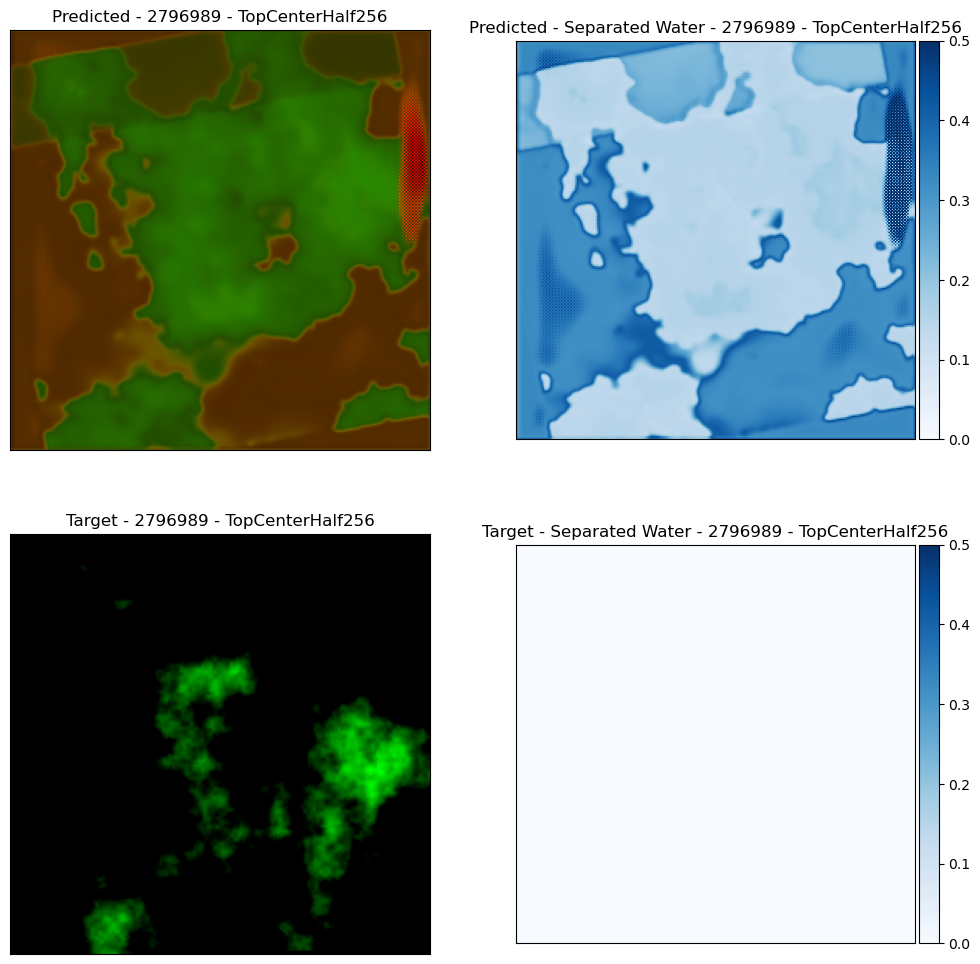

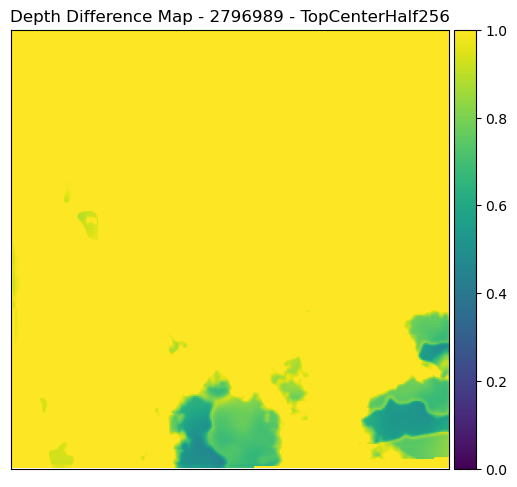

Train size: 600 | Train shape: torch.Size([2, 256, 256])
Validation size: 200 | Validation shape: torch.Size([2, 256, 256])
Test size: 200 | Test shape: torch.Size([2, 256, 256])
Using device: cuda


KeyboardInterrupt: 

In [466]:
transform = TF.Compose([
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    RandomRotation(degrees=15),
    Normalize(mean=[0.5]*4, std=[0.5]*4),
])

config = create_new_config(n_epochs=1, transforms=transform, plot_one_random=True)
experiment(config)
config['transforms'] = None
experiment(config)